## Load Data

In [0]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xfz ./aclImdb_v1.tar.gz

--2020-03-16 10:08:13--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  16.0MB/s    in 8.3s    

2020-03-16 10:08:27 (9.64 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
import os
import numpy as np

def get_files(dir):
  return [dir + d for d in os.listdir(dir) if os.path.isfile(dir + d)]

train_dir = '/content/aclImdb/train/'
test_dir = '/content/aclImdb/test/'

train_pos_files = get_files(train_dir + 'pos/')
train_neg_files = get_files(train_dir + 'neg/')

test_pos_files = get_files(test_dir + 'pos/')
test_neg_files = get_files(test_dir + 'neg/')

In [0]:
def get_data(files):
  temp = []
  for c in files:
    with open(c, 'r') as f:
      temp.append(f.read())
  return temp

train_pos = get_data(train_pos_files)
train_neg = get_data(train_neg_files)

test_pos = get_data(test_pos_files)
test_neg = get_data(test_neg_files)

## Data Processing

<ul>
  <li><b>Convert to lower case</b>
  <li><b>Remove Punctuation</b>
</ul>

In [0]:
from string import punctuation

def preprocess(data):
  for i in range(len(data)):
    s = data[i]
    s = s.replace('<br />', '')
    data[i] = ''.join([c for c in s.lower() if c not in punctuation])

  return data

train_pos = preprocess(train_pos)
train_neg = preprocess(train_neg)
test_pos = preprocess(test_pos)
test_neg = preprocess(test_neg)

## Tokenize

<li><b>Create word to index mapping dictionary</b>

There is a small trick here, in this mapping index will start from 0 i.e. mapping of ‘the’ will be 0. But later on we are going to do padding for shorter reviews and conventional choice for padding is 0. So we need to start this indexing from 1

In [0]:
from collections import Counter

words = ' '.join(train_pos + train_neg + test_pos + test_neg)
words = words.split()

count_words = Counter(words)
total = len(words)
sorted_words = count_words.most_common(total)

word2idx = {w:i+1 for i,(w,c) in enumerate(sorted_words)}

<li><b>Encode the words

In [0]:
def encode_words(data):
  data_idx = []
  for review in data:
    data_idx.append([word2idx[w] for w in review.split()])
  return data_idx

train_pos_idx = encode_words(train_pos)
train_neg_idx = encode_words(train_neg)
test_pos_idx = encode_words(test_pos)
test_neg_idx = encode_words(test_neg)

In [0]:
train_pos_labels = np.full(len(train_pos_idx), 1).tolist()
train_neg_labels = np.full(len(train_neg_idx), 0).tolist()
test_pos_labels = np.full(len(test_pos_idx), 1).tolist()
test_neg_labels = np.full(len(test_neg_idx), 0).tolist()

train_labels = train_pos_labels + train_neg_labels
test_labels = np.array(test_pos_labels + test_neg_labels)

In [0]:
train_reviews = train_pos + train_neg
train_reviews_idx = train_pos_idx + train_neg_idx
test_reviews_idx = test_pos_idx + test_neg_idx

In [0]:
train_reviews_idx = train_reviews_idx[:11250] + train_reviews_idx[13750:]
val_reviews_idx = train_reviews_idx[11250:13750]

train_labels = np.array(train_labels[:11250] + train_labels[13750:])
val_labels = np.array(train_labels[11250:13750])

## Analyze Reviews Length

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

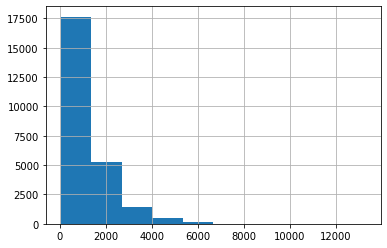

count    25000.000000
mean      1259.745280
std        954.738337
min         51.000000
25%        670.000000
50%        931.000000
75%       1532.000000
max      13286.000000
dtype: float64

In [0]:
reviews_len = [len(x) for x in train_reviews]
pd.Series(reviews_len).hist()
plt.show()

pd.Series(reviews_len).describe()

<li><b>Padding / Truncating the remaining data

In [0]:
import numpy as np

def pad_features(reviews, seq_length):
    ''' 
      Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews), seq_length), dtype = int)
    
    for i, review in enumerate(reviews):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [0]:
seq_length = 200
train_features = pad_features(train_reviews_idx, seq_length)
val_features = pad_features(val_reviews_idx, seq_length)
test_features = pad_features(test_reviews_idx, seq_length)

## Dataloaders and Batching

In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_features), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_features), torch.from_numpy(test_labels))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[   8,    6,  323,  ...,  194, 3333,    2],
        [   0,    0,    0,  ..., 2514,  411, 3115],
        [   0,    0,    0,  ...,    5,  859, 1090],
        ...,
        [   7,   10,   18,  ...,   61,  602, 3834],
        [   0,    0,    0,  ...,  354,   10,  969],
        [   0,    0,    0,  ..., 5849,  784,  646]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1])


## LSTM Model

<b>LSTM in Pytorch:</b><br>
Inputs: input, (h_0, c_0)<br>
Outputs: output, (h_n, c_n)<br>
<p>* This is the reason we create a tuple of two parameters for hidden state.</p>
<p>* For BiLSTM we should multiply number of hidden layers by two.</p>
<a href='https://discuss.pytorch.org/t/bidirectional-lstm-implementation/4037'> Pytorch Forum<a/>

In [0]:
import torch.nn as nn

class SentimentBiLSTM(nn.Module):
  def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
    super(SentimentBiLSTM, self).__init__()

    self.output_size = output_size
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True, bidirectional=True)

    self.dropout = nn.Dropout(0.3)

    self.fc = nn.Linear(hidden_dim, output_size)
    self.sig = nn.Sigmoid()

  def forward(self, x, hidden):
    batch_size = x.size(0)
    embeds =self.embedding(x)
    lstm_out, hidden = self.lstm(embeds, hidden)

    # stack up lstm outputs
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

    out = self.dropout(lstm_out)
    out = self.fc(out)
    # sigmoid function
    sig_out = self.sig(out)
        
    # reshape to be batch_size first
    sig_out = sig_out.view(batch_size, -1)
    sig_out = sig_out[:, -1] # get last batch of labels
        
    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data
      
    if (train_on_gpu):
        hidden = (weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_().cuda(),
                weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_().cuda())
    else:
        hidden = (weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_(),
                weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_())
        
    return hidden


## Training

In [0]:
# Instantiate the model w/ hyperparams
vocab_size = len(word2idx) + 1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
train_on_gpu = True

net = SentimentBiLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

In [0]:
lr=0.001
epochs = 4
counter = 0
print_every = 100
clip=5 # gradient clipping

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

if(train_on_gpu):
    net.cuda()

In [0]:
net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor).cuda()
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in val_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor).cuda()
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: 0.652669... Val Loss: 0.620840
Epoch: 1/4... Step: 200... Loss: 0.702466... Val Loss: 0.658140
Epoch: 1/4... Step: 300... Loss: 0.693225... Val Loss: 0.680569
Epoch: 1/4... Step: 400... Loss: 0.663828... Val Loss: 0.517838
Epoch: 2/4... Step: 500... Loss: 0.531397... Val Loss: 0.454757
Epoch: 2/4... Step: 600... Loss: 0.524250... Val Loss: 0.198840
Epoch: 2/4... Step: 700... Loss: 0.743830... Val Loss: 0.491184
Epoch: 2/4... Step: 800... Loss: 0.590345... Val Loss: 0.234661
Epoch: 2/4... Step: 900... Loss: 0.376590... Val Loss: 0.296031
Epoch: 3/4... Step: 1000... Loss: 0.303097... Val Loss: 0.621736
Epoch: 3/4... Step: 1100... Loss: 0.231349... Val Loss: 0.238768
Epoch: 3/4... Step: 1200... Loss: 0.303078... Val Loss: 0.160401
Epoch: 3/4... Step: 1300... Loss: 0.299275... Val Loss: 0.225852
Epoch: 4/4... Step: 1400... Loss: 0.200305... Val Loss: 0.065180
Epoch: 4/4... Step: 1500... Loss: 0.398797... Val Loss: 0.133489
Epoch: 4/4... Step: 1600... Loss: 

## Testing

In [0]:
# Get test data loss and accuracy
test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor).cuda()
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.471
Test accuracy: 0.818


## On user-generated data

In [0]:
from string import punctuation

def tokenize_review(test_review):
    test_review = test_review.lower() # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_review if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])

    return test_ints

# test code and generate tokenized review
test_ints = tokenize_review(test_review_neg)
print(test_ints)


# test sequence padding
seq_length=200
features = pad_features(test_ints, seq_length)

print(features)


# test conversion to tensor and pass into your model
feature_tensor = torch.from_numpy(features)
print(feature_tensor.size())


def predict(net, test_review, sequence_length=200):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")